# Inferential Statistics: California Housing
Raphassit Suwiwatchai

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro


In [2]:
# Here we would want to check the contents of each variables
df = pd.read_csv("dataset/California Houses.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# The dataset documentation said that this data is not yet been cleaned, so we need to run some checks first

#-------------- Check for null values --------------#
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
df = df.dropna() # Drop null values (minimal impact as our dataset contain over 20,000 datapoints)


Missing Values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


## Data Exploration (15 Points)
- Plot distributions of at least three numeric features (e.g. histograms, density plots).
- Compute mean and variance for the corresponding numeric features (and any additional summary statistics if desired)
- Identify any outliers in the distributions that lie outside three standard deviations from the mean.

Now the next step is to plot histogram, boxplot, and scatterplot for each variable to better visualise the data. The justification for each types of plots are as follows:

**Histogram:** Help us see the spread and skewness of data. It would also help us identify multi-modality (if any), to better visualise subgroups as well as revealing data concentrations.

**Box Plot:** Help identify outliers and understand the dataset;s variance.

**Scatter Plot:** Help identify relationship between variables, outliers, and clusters.

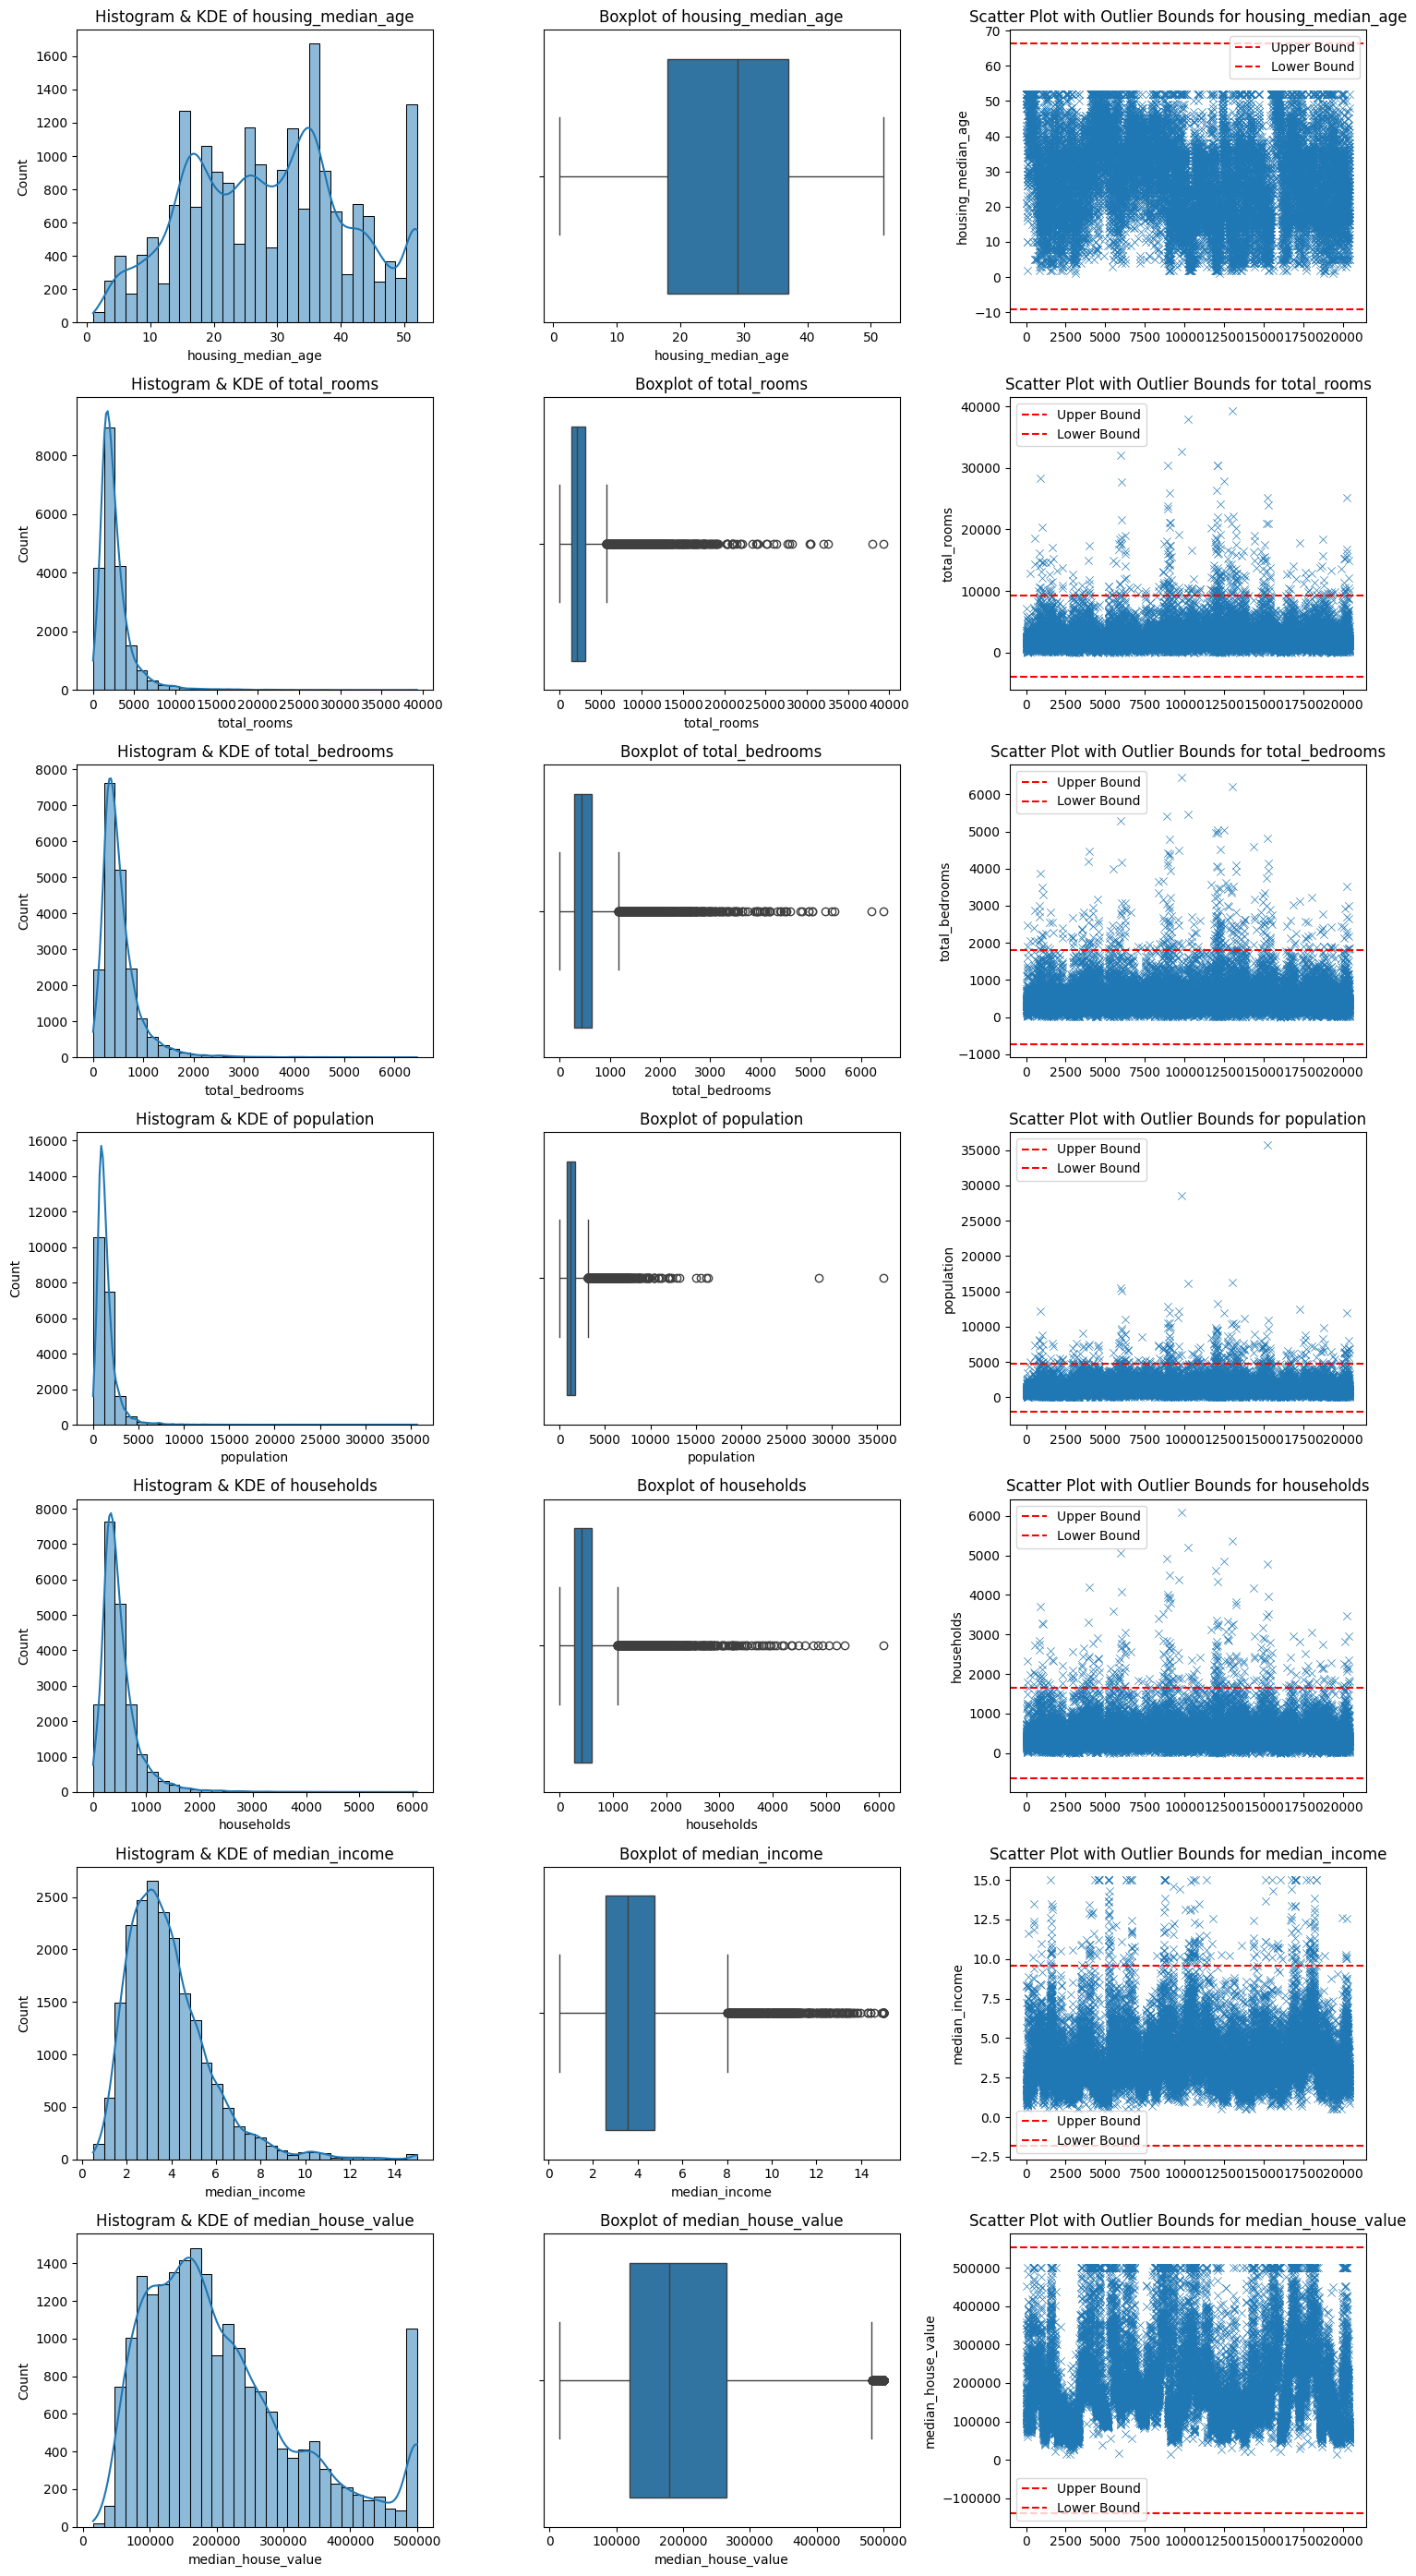

In [4]:
# We can't plot distribution for non-numeric features (remove string and spatial features)
numerical_columns = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

# Plot
fig, axes =plt.subplots(len(numerical_columns), 3, figsize=(15, 4 * len(numerical_columns)))

for i, feature in enumerate(numerical_columns):
    # Histogram & Density Plot
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram & KDE of {feature}')

    # Boxplot for Outliers
    sns.boxplot(x=df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {feature}')

    # Compute Outliers using the 3-sigma rule
    mean = df[feature].mean()
    std_dev = df[feature].std()
    threshold_upper = mean + 3 * std_dev
    threshold_lower = mean - 3 * std_dev

    # Scatter plot for potential outliers with 'x' markers
    sns.scatterplot(y=df[feature], x=np.arange(len(df)), marker='x', ax=axes[i, 2])
    axes[i, 2].axhline(threshold_upper, color='red', linestyle='dashed', label="Upper Bound")
    axes[i, 2].axhline(threshold_lower, color='red', linestyle='dashed', label="Lower Bound")
    axes[i, 2].set_title(f'Scatter Plot with Outlier Bounds for {feature}')
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

In [5]:
# Compute summary statistics
summary_stats = df[numerical_columns].describe()
print("Summary Statistics:\n", summary_stats)

# Identify Outliers
outlier_dict = {}
for feature in numerical_columns:
    mean = df[feature].mean()
    std_dev = df[feature].std()
    threshold_upper = mean + 3 * std_dev
    threshold_lower = mean - 3 * std_dev
    outlier_dict[feature] = df[(df[feature] > threshold_upper) | (df[feature] < threshold_lower)][feature].values

# Display outliers
outlier_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in outlier_dict.items()]))
print("Outliers Detected:\n", outlier_df)

Summary Statistics:
        housing_median_age   total_rooms  total_bedrooms    population  \
count        20433.000000  20433.000000    20433.000000  20433.000000   
mean            28.633094   2636.504233      537.870553   1424.946949   
std             12.591805   2185.269567      421.385070   1133.208490   
min              1.000000      2.000000        1.000000      3.000000   
25%             18.000000   1450.000000      296.000000    787.000000   
50%             29.000000   2127.000000      435.000000   1166.000000   
75%             37.000000   3143.000000      647.000000   1722.000000   
max             52.000000  39320.000000     6445.000000  35682.000000   

         households  median_income  median_house_value  
count  20433.000000   20433.000000        20433.000000  
mean     499.433465       3.871162       206864.413155  
std      382.299226       1.899291       115435.667099  
min        1.000000       0.499900        14999.000000  
25%      280.000000       2.563700  

The data show that the dataset is extremely skewed

## Verifying the Central Limit Theorem (CLT) (20 Points)

- Choose a numerica variable (with enough data) and draw repeated samples of various sizes (e.g. 10, 50, 200).
- For each sample size, compute the sample means repeatedly (like resampling approach)
- Visualise how these sample means distribute, and discuss how it relates to the Central Limit Theorem and the Law of Large Numbers

In [6]:
## -- PART A -- ##

# Selecting a variable to test CLT
variable = 'median_income'

# Sample sizes for CLT verification
sample_sizes = [10, 50, 200]
num_samples = 1000  # Number of random samples

# Generating sample means for each sample size
sample_means = {
    size: [df[variable].sample(size, replace=True).mean() for x in range(num_samples)] for size in sample_sizes
}

sample_means_df = pd.DataFrame(sample_means)

sample_means_df

,10,50,200
0,3.91859,3.981584,3.889593
1,3.24584,4.078672,3.874640
2,5.17244,4.534644,3.942234
3,3.83349,3.948158,3.872089
4,3.61435,3.530822,3.711738
...,...,...,...
995,3.53287,3.754438,3.913627
996,4.04607,3.900596,3.983784
997,3.96800,3.884316,4.030883
998,4.08259,3.781588,3.891732


In [7]:
## -- PART B -- ##
print("Summary Statistics for Sample Means:\n", sample_means_df.describe())

Summary Statistics for Sample Means:
                10           50           200
count  1000.000000  1000.000000  1000.000000
mean      3.915622     3.868188     3.868914
std       0.626811     0.259187     0.137599
min       2.445670     3.080038     3.499735
25%       3.480073     3.682362     3.780886
50%       3.855830     3.864709     3.856281
75%       4.341128     4.037285     3.957322
max       6.911300     4.999508     4.357934


The results show that while the mean is very close to each other, aligning with the dataset's mean. Standard deviation decreases as sample size increases and smaller sample size have wider range compared to bigger sample sizes.

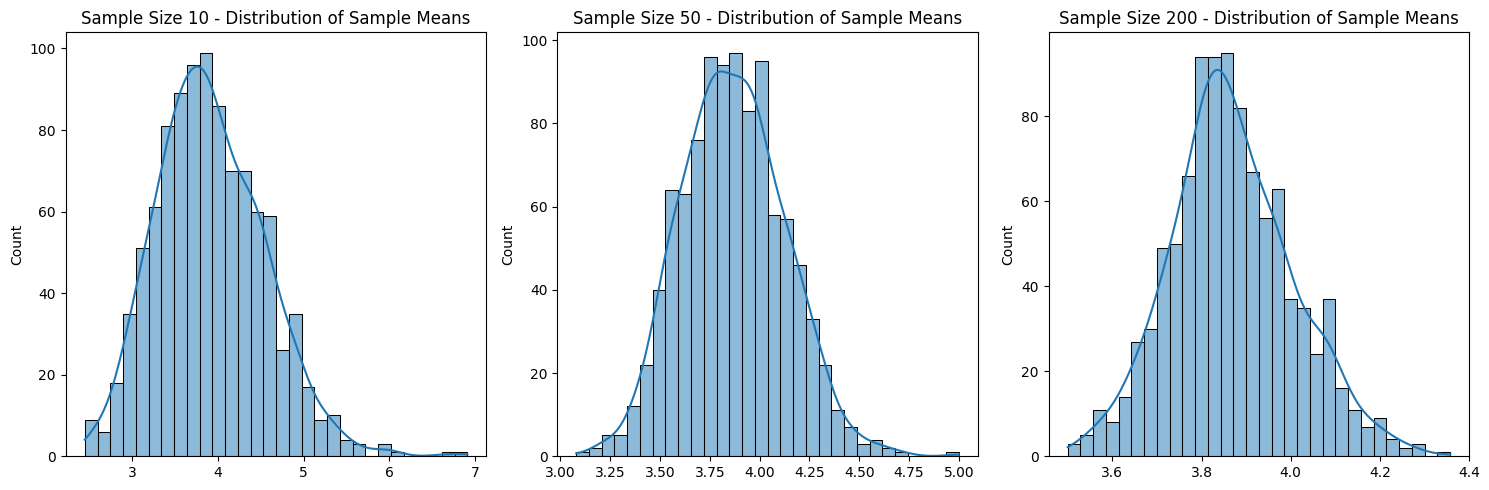

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, size in enumerate(sample_sizes):
    sns.histplot(sample_means[size], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Sample Size {size} - Distribution of Sample Means')

plt.tight_layout()
plt.show()

The histogram plot reinforces our finding, successfully validating CLT and confirms that inferential statistics can be applied to this dataset. To show mathematically prove that the distribution of sample mean tends towards normality as sample size increase, we can use Shapiro-Wilk test (dataset is big but not too big, making this test suitable).

In [9]:
shapiro_results = []

for size in sample_sizes:
    sample_data = sample_means[size]
    shapiro_stat, shapiro_p = shapiro(sample_data)

    shapiro_results.append([size, shapiro_stat, shapiro_p])

pd.DataFrame(shapiro_results, columns=["Sample Size", "Shapiro-Wilk Statistic", "p-value"])


,Sample Size,Shapiro-Wilk Statistic,p-value
0,10,0.985757,2.715926e-08
1,50,0.996142,1.383395e-02
2,200,0.993761,3.464704e-04


Looking at the p-value, we can see that when sample size =10, we reject normality (as 1.6e-10 << 0.5) and when sample size = 200, we fail to reject normality.

## Hypothesis Testing (25 Points)
- Perform at least one hypothesis test relevant to your dataset. For example (not exhaustive, you can come up with different ones):
    - Test whether the mean of a numeric feature equals a hypothesized value.– Compare means across two groups.
    - State the null and alternative hypotheses clearly, choose a significance level (e.g.α =0.05), show the test statistic or p-value, and interpret the result.
- Calculate confidence interval (you can pick the boundary)

In [11]:
## --- PART A --- ##
# Hypothesis: Do wealthier areas (high median income) have significantly larger homes (more total rooms)?

# Define the income threshold to separate groups
income_median_threshold = df['median_income'].median()

# Split data into low-income and high-income areas
low_income_rooms = df[df['median_income'] <= income_median_threshold]['total_rooms']
high_income_rooms = df[df['median_income'] > income_median_threshold]['total_rooms']

# Perform an independent t-test (Welch’s t-test for unequal variances)
t_stat, p_value = stats.ttest_ind(high_income_rooms, low_income_rooms, equal_var=False)

# Confidence Interval (95%)
confidence_interval = stats.t.interval(
    0.95, df=len(df)-1, loc=np.mean(high_income_rooms) - np.mean(low_income_rooms),
    scale=stats.sem(high_income_rooms) + stats.sem(low_income_rooms)
)

# Create a DataFrame for results
room_test_results_df = pd.DataFrame({
    "T-Statistic": [t_stat],
    "P-Value": [p_value],
    "Mean Difference": [np.mean(high_income_rooms) - np.mean(low_income_rooms)],
    "Confidence Interval Lower Bound": [confidence_interval[0]],
    "Confidence Interval Upper Bound": [confidence_interval[1]]
})

room_test_results_df

,T-Statistic,P-Value,Mean Difference,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,27.045452,8.017525e-158,812.539081,731.232604,893.845559


From the result, we can see that the P-value is extremely small where on average, higher income areas have 812 more rooms than lower income areas, where we are 95% sure of this. This could either mean that more people live in more wealthy area or wealthy individuals have bigger home or the combination of both.